Adding the Z

In [1]:
from glob import glob
import sys, scipy
from scipy.stats import chi2, poisson
import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

from prettytable import PrettyTable

In [2]:
import ROOT as rt
import root_numpy as rtnp
from utility_func import *

Welcome to JupyROOT 6.10/08


/Users/olmo/programs/root-6.10.08/lib/ROOT.py:318: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _orig_ihook( name, *args, **kwds )
Using TensorFlow backend.


In [112]:
from keras.layers import Input, Dense, Lambda, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
from keras.constraints import max_norm
import keras
print keras.__version__

2.1.2


In [55]:
import sklearn
print sklearn.__version__
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.metrics import roc_curve, auc

0.20.0


In [4]:
do_training = 1

# Get the samples

In [5]:
hlf_features = ['HT', 'METp', 'METo', 'MT', 'nJets', 
                'bJets', 'allJetMass', 'LepPt', 'LepEta', 
                'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu', 'LepCharge', 
                'LepIsEle', 'nMu', 'allMuMass', 'allMuPt', 'nEle', 
                'allEleMass', 'allElePt', 'nChHad', 'nNeuHad', 'nPhoton']

active_hlf_features = ['HT', 'allJetMass',
                       'allMuPt', 'allMuMass',
                       'allElePt','allEleMass',
                       'LepPt', 'LepIsoCh', 'LepIsoGamma', 'LepIsoNeu',
                       
                       'METp', 'METo',
                       
                       'MT',
                       
                       'nMu', 'nJets', 'bJets', 'nEle', 
                       
                       'LepCharge','LepIsEle', 
                       
                       'nChHad', 'nNeuHad']

Nf_lognorm = 10
Nf_gauss = 2
Nf_Pgauss = 1
Nf_PDgauss = 4
Nf_binomial = 2
Nf_poisson = 2

sel = []
for a in active_hlf_features:
    for i,f in enumerate(hlf_features):
        if a == f:
            sel.append(i)
# print 'Activated HLF:'
# for n in np.array(hlf_features)[sel]:
#     print '\t', n

In [6]:
data_folder = '../../data/HLF_ONLY/'
TrainSamplesName = ['Wlnu', 'qcd', 'Zll', 'ttbar']
BSM_samples = ['Ato4l', 'Zprime', 'Wprime', 'leptoquark']

N_train_max = int(2e6)

In [7]:
fraction = np.array([0.592, 0.338, 0.067, 0.003])

raw_sample = {}
l = np.zeros(4)
for i,n in enumerate(TrainSamplesName):
    raw_sample[n] = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    l[i] = raw_sample[n].shape[0]
    
i_min = np.argmin(l/fraction)
print 'Limiting stat. sample:', TrainSamplesName[i_min]

N_train = min(0.8*l[i_min], N_train_max)

x_train_s = {}
x_val_s = {}

table = PrettyTable(['Sample', 'Evts tot', 'Train', 'Val'])

for i,n in enumerate(TrainSamplesName):
    N_train_aux = int(N_train * fraction[i]/fraction[i_min])
    x_train_s[n] = raw_sample[n][:N_train_aux, sel]
    x_val_s[n] = raw_sample[n][N_train_aux : int(N_train_aux*1.2) - 1, sel]
    table.add_row([n, raw_sample[n].shape[0], N_train_aux, x_val_s[n].shape[0]])
print table
    
x_train = np.concatenate((x_train_s['Wlnu'], x_train_s['qcd'], x_train_s['Zll'], x_train_s['ttbar']))
x_val = np.concatenate((x_val_s['Wlnu'], x_val_s['qcd'], x_val_s['Zll'], x_val_s['ttbar']))

Limiting stat. sample: qcd
+--------+----------+---------+--------+
| Sample | Evts tot |  Train  |  Val   |
+--------+----------+---------+--------+
|  Wlnu  | 5003421  | 1634053 | 326809 |
|  qcd   | 1166195  |  932956 | 186590 |
|  Zll   | 1777383  |  184935 | 36986  |
| ttbar  | 5001726  |   8280  |  1655  |
+--------+----------+---------+--------+


In [8]:
x_sig = {}
for n in BSM_samples:
    s = np.load(data_folder+n+'_lepFilter_13TeV_sample.npy')
    x_sig[n] = s[:N_train_max, sel]

# Start the Classifier declaration

In [9]:
original_dim = x_train.shape[1]
intermediate_dim = 15
act_fun = 'relu'
clf = {}

### Do the training

In [10]:
n = 'Ato4l'

if do_training:
    inputs = Input(shape=(original_dim,), name='Input_'+n)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h1_'+n)(inputs)
    #     mdl = Dropout(0.2)(mdl)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h2_'+n)(mdl)
    mdl = Dropout(0.25)(mdl)
    mdl = Dense(1, activation='sigmoid', name='out_'+n)(mdl)
    clf[n] = Model(inputs=inputs, outputs=mdl)

    clf[n].compile(loss='binary_crossentropy', optimizer='adam')

    print '\n\n------------------ Training', n, '--------------------'
    l_bsm = int(x_sig[n].shape[0]*0.8)
    aux_x = np.concatenate(( x_train, x_sig[n][:l_bsm] ))
    aux_y = np.concatenate(( np.zeros(x_train.shape[0]), np.ones(l_bsm) ))
    aux_xval = np.concatenate(( x_val, x_sig[n][l_bsm:] ))
    aux_yval = np.concatenate(( np.zeros(x_val.shape[0]), np.ones(x_sig[n].shape[0] - l_bsm) ))

    clf[n].training_history = clf[n].fit(x=aux_x, y=aux_y, batch_size=1000, epochs=50,
                          shuffle=True,
                          validation_data= (aux_xval, aux_yval),
                          callbacks = [
                                        EarlyStopping(monitor='val_loss', patience=4, verbose=1),
                                        ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1),
                                        TerminateOnNaN()
                                      ]
                         )
else:
    clf[n].load('Classifier_'+n+'_v1.h5')



------------------ Training Ato4l --------------------
Train on 2798390 samples, validate on 561582 samples
Epoch 1/50
2798390/2798390 [==============================] - 7s 3us/step - loss: 0.2968 - val_loss: 0.2739
Epoch 2/50
2798390/2798390 [==============================] - 7s 3us/step - loss: 0.2201 - val_loss: 0.2739
Epoch 3/50
2798390/2798390 [==============================] - 8s 3us/step - loss: 0.2199 - val_loss: 0.2739
Epoch 4/50
2798390/2798390 [==============================] - 7s 3us/step - loss: 0.1197 - val_loss: 0.0351
Epoch 5/50
2798390/2798390 [==============================] - 8s 3us/step - loss: 0.0314 - val_loss: 0.0330
Epoch 6/50
2798390/2798390 [==============================] - 8s 3us/step - loss: 0.0286 - val_loss: 0.0293
Epoch 7/50
2798390/2798390 [==============================] - 7s 3us/step - loss: 0.0268 - val_loss: 0.0272
Epoch 8/50
2798390/2798390 [==============================] - 8s 3us/step - loss: 0.0262 - val_loss: 0.0268
Epoch 9/50
2798390/2798390

2018-10-23 16:12:26.203869: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.2 AVX AVX2 FMA


In [140]:
n = 'Zprime'
if do_training:
    intermediate_dim = 50
    inputs = Input(shape=(original_dim,), name='Input_'+n)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h1_'+n, kernel_constraint=max_norm(2.))(inputs)
    mdl = Dropout(0.4)(mdl)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h2_'+n, kernel_constraint=max_norm(2.))(mdl)
    mdl = Dropout(0.4)(mdl)
    mdl = Dense(1, activation='sigmoid', name='out_'+n)(mdl)
    clf[n] = Model(inputs=inputs, outputs=mdl)

    clf[n].compile(loss='binary_crossentropy', optimizer='adam')

    print '\n\n------------------ Training', n, '--------------------'
    l_bsm = int(x_sig[n].shape[0]*0.8)
    aux_x = np.concatenate(( x_train, x_sig[n][:l_bsm] ))
    aux_y = np.concatenate(( np.zeros(x_train.shape[0]), np.ones(l_bsm) ))
    aux_xval = np.concatenate(( x_val, x_sig[n][l_bsm:] ))
    aux_yval = np.concatenate(( np.zeros(x_val.shape[0]), np.ones(x_sig[n].shape[0] - l_bsm) ))

    clf[n].training_history = clf[n].fit(x=aux_x, y=aux_y, batch_size=1000, epochs=40,
                          shuffle=True,
                          validation_data= (aux_xval, aux_yval),
                          callbacks = [
                                        EarlyStopping(monitor='val_loss', patience=4, verbose=1),
                                        ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1),
                                        TerminateOnNaN()
                                      ]
                         )
else:
    clf[n].load('Classifier_'+n+'_v1.h5')



------------------ Training Zprime --------------------
Train on 2804513 samples, validate on 563113 samples
Epoch 1/40
2804513/2804513 [==============================] - 12s 4us/step - loss: 0.3163 - val_loss: 0.3169
Epoch 2/40
2804513/2804513 [==============================] - 10s 4us/step - loss: 0.2545 - val_loss: 0.3169
Epoch 3/40
2804513/2804513 [==============================] - 10s 4us/step - loss: 0.0948 - val_loss: 0.0602
Epoch 4/40
2804513/2804513 [==============================] - 10s 4us/step - loss: 0.0496 - val_loss: 0.0495
Epoch 5/40
2804513/2804513 [==============================] - 10s 4us/step - loss: 0.0442 - val_loss: 0.0468
Epoch 6/40
2804513/2804513 [==============================] - 10s 4us/step - loss: 0.0433 - val_loss: 0.0466
Epoch 7/40
2804513/2804513 [==============================] - 10s 4us/step - loss: 0.0428 - val_loss: 0.0465
Epoch 8/40
2804513/2804513 [==============================] - 10s 4us/step - loss: 0.0426 - val_loss: 0.0482
Epoch 9/40
280451

In [119]:
n = 'Wprime'
if do_training:
    intermediate_dim = 50
    inputs = Input(shape=(original_dim,), name='Input_'+n)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h1_'+n, kernel_constraint=max_norm(2.))(inputs)
    mdl = Dropout(0.4)(mdl)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h2_'+n, kernel_constraint=max_norm(2.))(mdl)
    mdl = Dropout(0.5)(mdl)
    mdl = Dense(1, activation='sigmoid', name='out_'+n)(mdl)
    clf[n] = Model(inputs=inputs, outputs=mdl)

    clf[n].compile(loss='binary_crossentropy', optimizer='adam')

    print '\n\n------------------ Training', n, '--------------------'
    l_bsm = int(x_sig[n].shape[0]*0.8)
    aux_x = np.concatenate(( x_train, x_sig[n][:l_bsm] ))
    aux_y = np.concatenate(( np.zeros(x_train.shape[0]), np.ones(l_bsm) ))
    aux_xval = np.concatenate(( x_val, x_sig[n][l_bsm:] ))
    aux_yval = np.concatenate(( np.zeros(x_val.shape[0]), np.ones(x_sig[n].shape[0] - l_bsm) ))

    clf[n].training_history = clf[n].fit(x=aux_x, y=aux_y, batch_size=1000, epochs=30,
                          shuffle=True,
                          validation_data= (aux_xval, aux_yval),
                          callbacks = [
                                        EarlyStopping(monitor='val_loss', patience=3, verbose=1),
                                        ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1),
                                        TerminateOnNaN()
                                      ]
                         )
else:
    clf[n].load('Classifier_'+n+'_v1.h5')



------------------ Training Wprime --------------------
Train on 3244753 samples, validate on 673173 samples
Epoch 1/30
3244753/3244753 [==============================] - 13s 4us/step - loss: 0.9596 - val_loss: 0.4368
Epoch 2/30
3244753/3244753 [==============================] - 12s 4us/step - loss: 0.3866 - val_loss: 0.4200
Epoch 3/30
3244753/3244753 [==============================] - 12s 4us/step - loss: 0.3783 - val_loss: 0.4159
Epoch 4/30
3244753/3244753 [==============================] - 12s 4us/step - loss: 0.3749 - val_loss: 0.4131
Epoch 5/30
3244753/3244753 [==============================] - 12s 4us/step - loss: 0.3732 - val_loss: 0.4111
Epoch 6/30
3244753/3244753 [==============================] - 12s 4us/step - loss: 0.3719 - val_loss: 0.4122
Epoch 7/30
3244753/3244753 [==============================] - 12s 4us/step - loss: 0.3711 - val_loss: 0.4100
Epoch 8/30
3244753/3244753 [==============================] - 12s 4us/step - loss: 0.3706 - val_loss: 0.4088
Epoch 9/30
324475

In [136]:
n = 'leptoquark'
if do_training:
    intermediate_dim = 40
    inputs = Input(shape=(original_dim,), name='Input_'+n)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h1_'+n, kernel_constraint=max_norm(2.))(inputs)
    mdl = Dropout(0.3)(mdl)
    mdl = Dense(intermediate_dim, activation=act_fun, name='h2_'+n, kernel_constraint=max_norm(2.))(mdl)
    mdl = Dropout(0.4)(mdl)
    mdl = Dense(1, activation='sigmoid', name='out_'+n)(mdl)
    clf[n] = Model(inputs=inputs, outputs=mdl)

    clf[n].compile(loss='binary_crossentropy', optimizer='adam')

    print '\n\n------------------ Training', n, '--------------------'
    l_bsm = int(x_sig[n].shape[0]*0.8)
    aux_x = np.concatenate(( x_train, x_sig[n][:l_bsm] ))
    aux_y = np.concatenate(( np.zeros(x_train.shape[0]), np.ones(l_bsm) ))
    aux_xval = np.concatenate(( x_val, x_sig[n][l_bsm:] ))
    aux_yval = np.concatenate(( np.zeros(x_val.shape[0]), np.ones(x_sig[n].shape[0] - l_bsm) ))

    clf[n].training_history = clf[n].fit(x=aux_x, y=aux_y, batch_size=500, epochs=40,
                          shuffle=True,
                          validation_data= (aux_xval, aux_yval),
                          callbacks = [
                                        EarlyStopping(monitor='val_loss', patience=4, verbose=1),
                                        ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1),
                                        TerminateOnNaN()
                                      ]
                         )
else:
    clf[n].load('Classifier_'+n+'_v1.h5')



------------------ Training leptoquark --------------------
Train on 2979107 samples, validate on 606761 samples
Epoch 1/30
2979107/2979107 [==============================] - 17s 6us/step - loss: 0.4134 - val_loss: 0.2085
Epoch 2/30
2979107/2979107 [==============================] - 16s 5us/step - loss: 0.1824 - val_loss: 0.1950
Epoch 3/30
2979107/2979107 [==============================] - 16s 5us/step - loss: 0.1819 - val_loss: 0.1926
Epoch 4/30
2979107/2979107 [==============================] - 15s 5us/step - loss: 0.1810 - val_loss: 0.1838
Epoch 5/30
2979107/2979107 [==============================] - 16s 5us/step - loss: 0.1797 - val_loss: 0.1901
Epoch 6/30
2979107/2979107 [==============================] - 16s 5us/step - loss: 0.1792 - val_loss: 0.1869
Epoch 7/30
2973000/2979107 [============================>.] - ETA: 0s - loss: 0.1810
Epoch 00007: reducing learning rate to 0.00010000000475.
2979107/2979107 [==============================] - 16s 5us/step - loss: 0.1810 - val_loss

In [14]:
Eff_SM = 8.06e-06

In [120]:
n = 'Wprime'
p_SM = clf[n].predict(x_train, batch_size=2000)
p_BSM = clf[n].predict(x_sig[n], batch_size=2000)

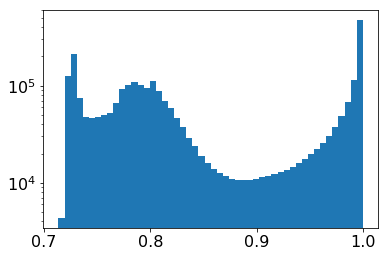

In [121]:
plt.hist(1-p_SM, bins=50)
plt.yscale('log')

In [127]:
def ROC_curve(p_BSM, p_SM, eval_q_SM):
    eval_p = np.percentile(1-p_SM, q=100*eval_q_SM)
    
    out = (1-p_BSM) < eval_p
    out = np.sum(out, axis=0)
    q_BSM = out/float(p_BSM.shape[0])
    
    AUC = np.trapz(q_BSM, eval_q_SM)
    
    return q_BSM, AUC

Ato4l: 1.52e-01
Zprime: 7.86e-03
Wprime: 1.65e-05
leptoquark: 2.30e-03


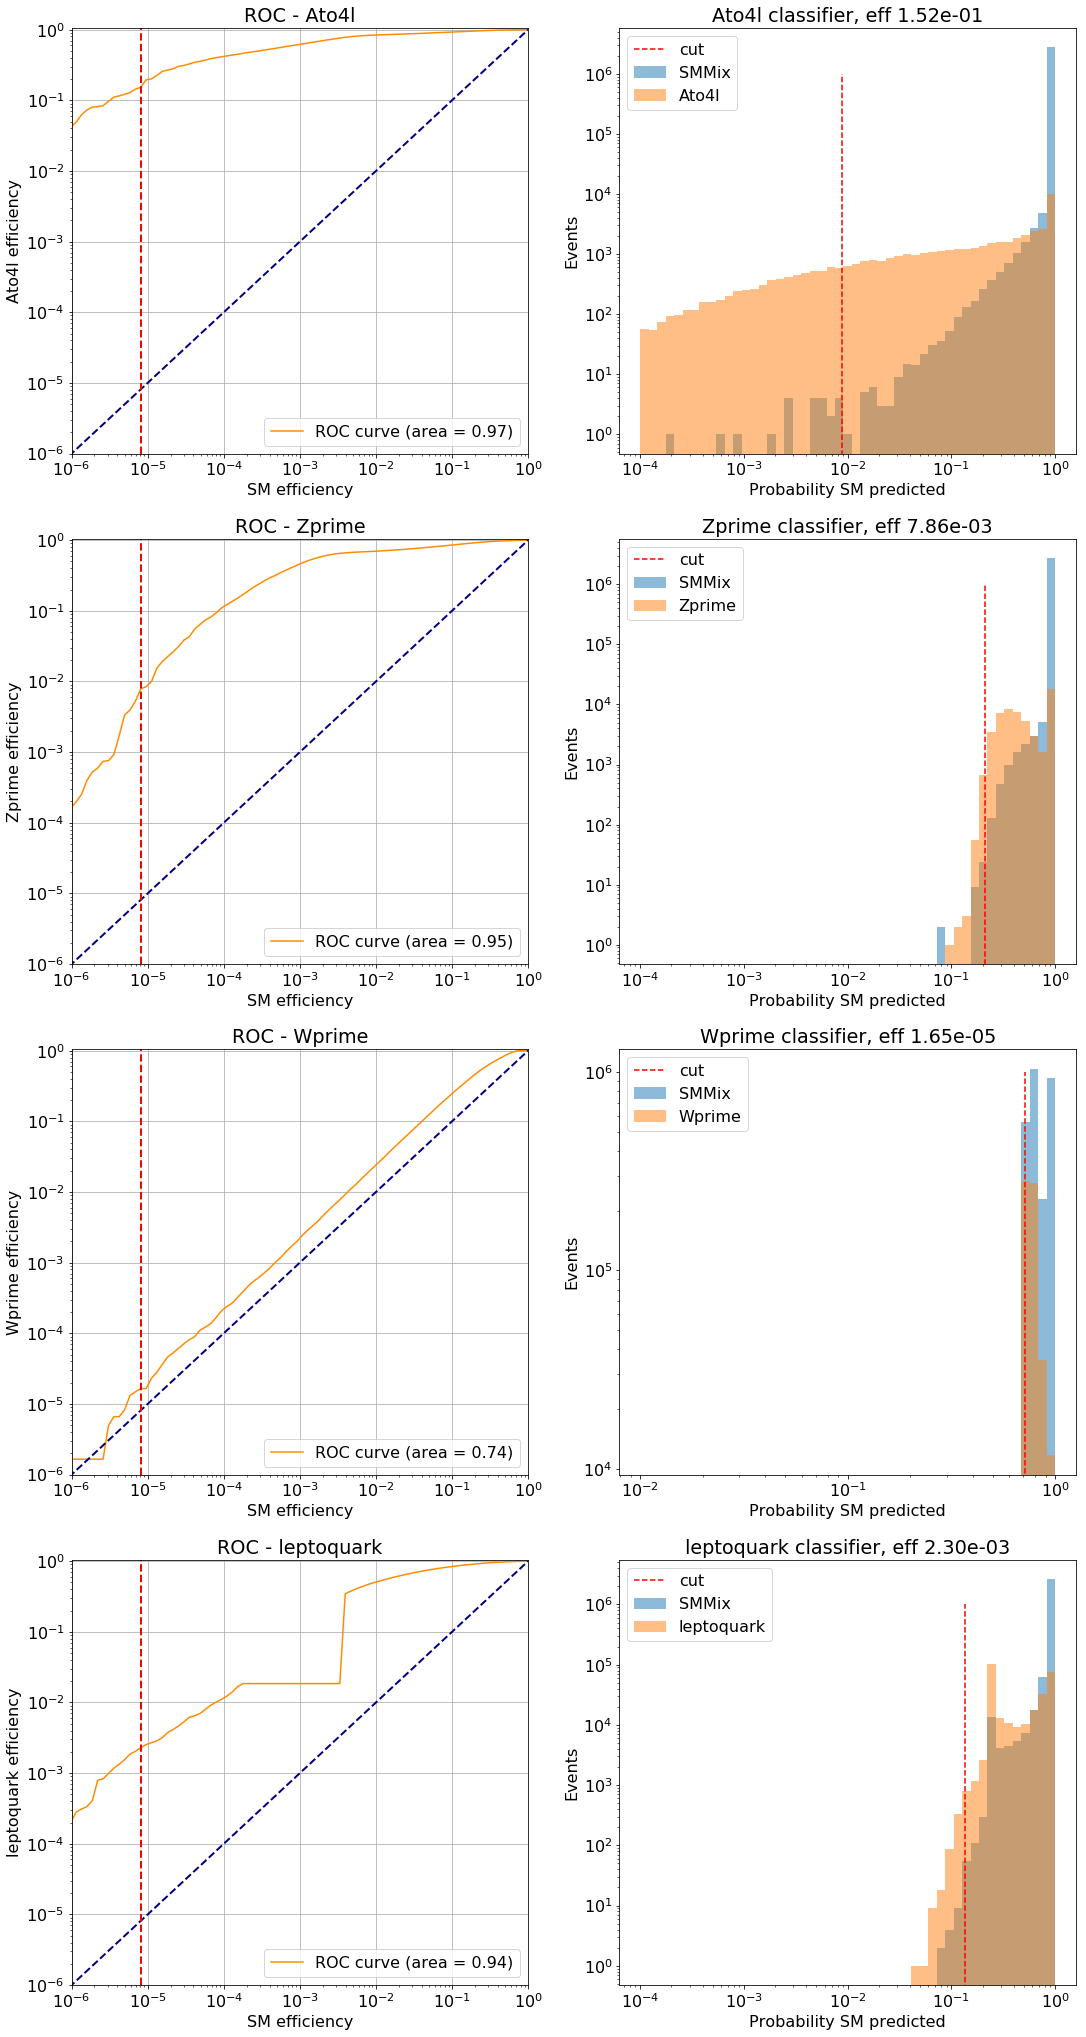

In [137]:
matplotlib.rcParams.update({'font.size': 16})

f, ax_arr = plt.subplots(len(BSM_samples),2 , figsize=(18,36))

for i,n in enumerate(BSM_samples):
    p_SM = clf[n].predict(x_train, batch_size=2000)
    p_BSM = clf[n].predict(x_sig[n], batch_size=2000)
    
    # print ROC curve
    q_SM = np.logspace(base=10, start=-7, stop=0, num=100)
    q_BSM, roc_auc = ROC_curve(p_BSM, p_SM, q_SM)
    
    ax_arr[i,0].plot(q_SM, q_BSM, color='darkorange', label='ROC curve (area = {:0.2f})'.format(roc_auc))
    ax_arr[i,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax_arr[i,0].plot([Eff_SM, Eff_SM], [1e-6, 1.05], color='red', lw=2, linestyle='--')
    ax_arr[i,0].set_xlim([1e-6, 1.0])
    ax_arr[i,0].set_ylim([1e-6, 1.05])
    ax_arr[i,0].set_xlabel('SM efficiency')
    ax_arr[i,0].set_ylabel(n+' efficiency')
    ax_arr[i,0].set_title('ROC - ' + n)
    ax_arr[i,0].legend(loc="lower right")
    ax_arr[i,0].set_yscale('log')
    ax_arr[i,0].set_xscale('log')
    ax_arr[i,0].grid()
    
    

    q = np.percentile(p_SM, 100*(1-Eff_SM))
    eff_BSM = float(np.sum(p_BSM>q))/x_sig[n].shape[0]

    print '{}: {:1.2e}'.format(n, eff_BSM)
    
    bins = np.logspace(base=10, start=-4, stop=0, num=50)
    if n=='Wprime':
        bins = np.logspace(base=10, start=-2, stop=0, num=50)
    ax_arr[i,1].hist(1-p_SM, bins=bins, alpha = 0.5, label='SMMix')
    ax_arr[i,1].hist(1-p_BSM, bins=bins, alpha=0.5, label=n)
    ax_arr[i,1].plot([1-q,1-q], [0,1e6], '--r', label='cut')

    ax_arr[i,1].set_title('{} classifier, eff {:1.2e}'.format(n, eff_BSM))
    ax_arr[i,1].legend(loc='best')
    ax_arr[i,1].set_ylabel('Events')
    ax_arr[i,1].set_xlabel('Probability SM predicted')
    ax_arr[i,1].set_yscale('log')
    ax_arr[i,1].set_xscale('log')

In [126]:
for k,c in clf.iteritems():
    c.save('Classifier_'+k+'_v1.h5')